In [1]:
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

In [2]:
# Because we use shuffle
SEED = 99
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# Set compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [5]:
# No need to flatten but need to change this to 150 x 12
train_x = np.squeeze(training_set['x'])
train_y =  np.squeeze(training_set['y'])

print(train_x.shape)
print(train_y.shape)

(9157, 12, 150)
(9157, 12, 150)


In [6]:
n_nodes= 150
train_x_new = []

for i in range(n_nodes):
    samples_collect = []
    for j in range(len(train_x)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(train_x[j,:,k])
    train_x_new.append(samples_collect)
    
train_x_new = np.array(train_x_new)
print(train_x_new.shape)

(150, 9157, 12)


In [7]:
# verify: 
print(train_x[1005][5][112])
print(train_x_new[112][1005][5])

294.0
294.0


In [8]:
train_y_new = []

for i in range(n_nodes):
    samples_collect = []
    for j in range(len(train_y)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(train_y[j,:,k])
    train_y_new.append(samples_collect)
    
train_y_new = np.array(train_y_new)
print(train_y_new.shape)

(150, 9157, 12)


In [9]:
# verify: 
print(train_y[1000][5][112])
print(train_y_new[112][1000][5])

3058.0
3058.0


In [10]:
# Data must be normalized, Duh!!
print(np.max(train_x_new))
print(np.max(train_y_new))

#train_x_new = (train_x_new - mean)/ std
#train_y_new = (train_y_new - mean)/ std
#Normalizer = np.max(train_x_new)

#train_x_new = train_x_new/ Normalizer
#train_y_new = train_y_new/ Normalizer

print(np.max(train_x_new))
print(np.max(train_y_new))

13442.0
13442.0
13442.0
13442.0


In [11]:
# Define dataset
class TR_dataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        
    def __len__(self):
        assert len(self.target_list) == len(self.data_list)
        return len(self.data_list)

    def __getitem__(self, key):
        input_seq = self.data_list[key]
        targets = self.target_list[key]
        return [input_seq,targets]

In [12]:
# model
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [13]:
inputDim = 12     
outputDim = 12   

n_models = 150
models=[]

for i in range(n_models):
    models.append(linearRegression(inputDim, outputDim))

In [14]:
#models[10].eval()

In [15]:
BATCH_SIZE = 1

data_loaders =[]
for i in range(n_models):
    train_set = TR_dataset(train_x_new[i], train_y_new[i])
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=True)
    data_loaders.append(train_dataloader)

In [16]:
learningRate = 0.001 
criterion = nn.MSELoss(reduction='mean')

In [17]:
def bulk_train(epochs, model_list, iterator_list, criterion, learningRate):
    
    losses_collect=[]
    for i in range(len(model_list)):
        
        print("xxxxxxxxxxxxxxxxxxxx")
        print("For model:", i + 1)
        print("xxxxxxxxxxxxxxxxxxxx")
        
        model = model_list[i]
        model.to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=learningRate)
        
        model_name = "model_" + str(i)
        save_location =  "./lr/best_models/best_{}.pt".format(model_name)
        
        epoch_loss = 0
        epoch_losses_collect=[]
        best_loss = float('inf')
        
        for j in range(epochs):

            model.train()

            for k, (batch_input, batch_target) in enumerate(iterator_list[i]):
                
                batch_input = batch_input.float().to(device)
                batch_target = batch_target.float().to(device)
                
                optimizer.zero_grad()
                
                output = model(batch_input)
                
                mse_loss = criterion(output, batch_target)
                
                loss = torch.sqrt(mse_loss)
                
                loss.backward()
                
                optimizer.step()
                
                epoch_loss+=loss.cpu().detach().numpy()
                
            avg_batch_loss = epoch_loss/len(iterator_list[i]) 
            epoch_losses_collect.append(avg_batch_loss)
                    
            if avg_batch_loss < best_loss:
                best_loss = avg_batch_loss
                torch.save(model_list[i], save_location)
        
            print("Unnormalized average batch loss per epoch:", avg_batch_loss)
        
        # num_models x num_epochs
        losses_collect.append(epoch_losses_collect)
    return losses_collect

In [18]:
num_epochs = 1
losses = bulk_train(num_epochs, models, data_loaders, criterion, learningRate)

xxxxxxxxxxxxxxxxxxxx
For model: 1
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1767.328753969718
xxxxxxxxxxxxxxxxxxxx
For model: 2
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1534.7292645046045
xxxxxxxxxxxxxxxxxxxx
For model: 3
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1791.1448036652928
xxxxxxxxxxxxxxxxxxxx
For model: 4
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1852.550530593937
xxxxxxxxxxxxxxxxxxxx
For model: 5
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1969.2594626571356
xxxxxxxxxxxxxxxxxxxx
For model: 6
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1844.5483298389702
xxxxxxxxxxxxxxxxxxxx
For model: 7
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1926.5924461450563
xxxxxxxxxxxxxxxxxxxx
For model: 8
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1647.9912301955349
xxxxxxxxxxxxxxxxxxxx
For model: 9
xxxxxxxxxxxxxxxxxxxx
Unnormalize

Unnormalized average batch loss per epoch: 1703.041416771016
xxxxxxxxxxxxxxxxxxxx
For model: 72
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1810.5346448697728
xxxxxxxxxxxxxxxxxxxx
For model: 73
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 506.37947217535736
xxxxxxxxxxxxxxxxxxxx
For model: 74
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1284.9664533697805
xxxxxxxxxxxxxxxxxxxx
For model: 75
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1234.9066866076616
xxxxxxxxxxxxxxxxxxxx
For model: 76
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 754.6109282200001
xxxxxxxxxxxxxxxxxxxx
For model: 77
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 885.6797581400116
xxxxxxxxxxxxxxxxxxxx
For model: 78
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1822.6433818467622
xxxxxxxxxxxxxxxxxxxx
For model: 79
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1332.01264212253

Unnormalized average batch loss per epoch: 1846.8489043412933
xxxxxxxxxxxxxxxxxxxx
For model: 142
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 2045.0254129641205
xxxxxxxxxxxxxxxxxxxx
For model: 143
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1782.8903160482641
xxxxxxxxxxxxxxxxxxxx
For model: 144
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 2222.5748027831924
xxxxxxxxxxxxxxxxxxxx
For model: 145
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 2168.666854128536
xxxxxxxxxxxxxxxxxxxx
For model: 146
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1110.2051202295597
xxxxxxxxxxxxxxxxxxxx
For model: 147
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1773.0874594563127
xxxxxxxxxxxxxxxxxxxx
For model: 148
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1212.8563672813823
xxxxxxxxxxxxxxxxxxxx
For model: 149
xxxxxxxxxxxxxxxxxxxx
Unnormalized average batch loss per epoch: 1384.8

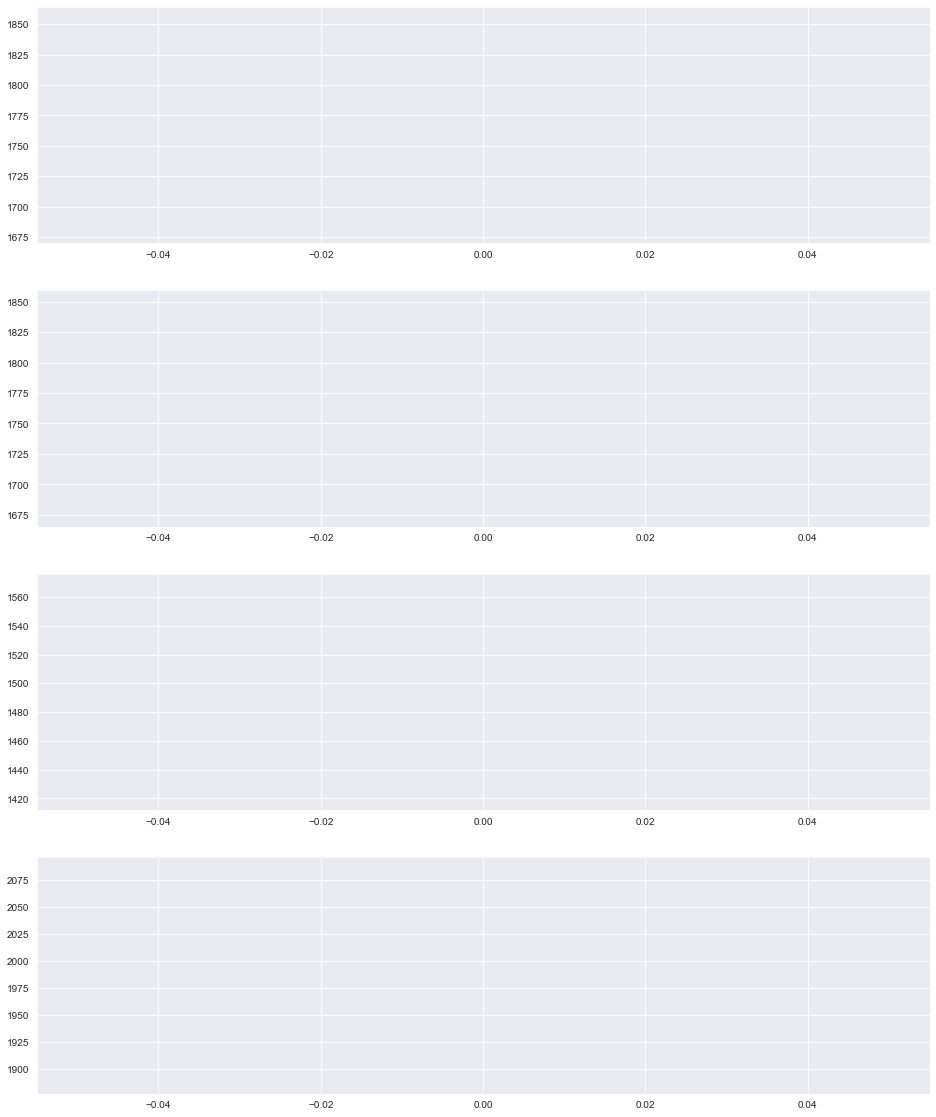

In [19]:
# plot a few
# models 0 , 50, 100, 150

index_list = [0, 50, 100, 149]

x = np.arange(num_epochs)
fig, ax = plt.subplots(4,1,figsize=(16,5*4))

for i in range(len(index_list)):
    ax[i].plot(x, losses[index_list[i]])

In [20]:
# load all pretrained models
paths = glob.glob('./lr/best_models/*.pt')
print(len(paths))

trained_models = []
for i in paths:
    trained_models.append(torch.load(i))
    
print(len(trained_models))

150
150


In [21]:
test_set = np.load('./data/test.npz')

test_x = np.squeeze(test_set['x'])
test_y = np.squeeze(test_set['y'])

print(test_x.shape, np.max(test_x))
print(test_y.shape, np.max(test_y))

(2616, 12, 150) 11644.0
(2616, 12, 150) 11644.0


In [22]:
test_x_new =[]
for i in range(n_nodes):
    samples_collect = []
    for j in range(len(test_x)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(test_x[j,:,k])
    test_x_new.append(samples_collect)
    
test_x_new = np.array(test_x_new)
#test_x_new = test_x_new / Normalizer

#test_x_new = (test_x_new- mean)/ std

print(np.max(test_x_new), test_x_new.shape)

11644.0 (150, 2616, 12)


In [23]:
test_y_new =[]
for i in range(n_nodes):
    samples_collect = []
    for j in range(len(test_y)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(test_y[j,:,k])
    test_y_new.append(samples_collect)
    
test_y_new = np.array(test_y_new)
#test_y_new = test_y_new / Normalizer

#test_y_new = (test_y_new- mean)/ std

print(np.max(test_y_new),test_y_new.shape)

11644.0 (150, 2616, 12)


In [24]:
TEST_BATCH_SIZE = 1

test_data_loaders =[]
for i in range(n_nodes):
    
    test_set = TR_dataset(test_x_new[i], test_y_new[i])

    test_dataloader = torch.utils.data.DataLoader(dataset=test_set,
                                                   batch_size=TEST_BATCH_SIZE,
                                                   collate_fn=None,
                                                   shuffle=False)
    
    test_data_loaders.append(test_dataloader)

In [25]:
outputs = []

for i in range(len(trained_models)):
    
    new_model = trained_models[i].eval()
    new_model.to(device)
    
    output_model = []
    
    with torch.no_grad():
        
        # enumerate the iterator correponding to the model
        for bi, (data, target) in enumerate(test_data_loaders[i]):
            
            data_batch, label_batch = data.float().to(device), target.float().to(device)
            
            output_batch = new_model(data_batch)
            
            output_batch_numpy = output_batch.cpu().detach().numpy()
            
            #print(output_batch_numpy.shape)
            
            output_model.append(np.squeeze(output_batch_numpy))
            
    outputs.append(output_model)
    
outputs = np.array(outputs)
print(outputs.shape)
np.save('./lr/linear_model_output.npy', outputs)

(150, 2616, 12)


In [26]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [27]:
outputs_lr = np.load('./lr/linear_model_output.npy', allow_pickle = True) 
print("Shape = {}, max = {}, mean = {}".format(outputs_lr.shape, np.max(outputs_lr), np.mean(outputs_lr)))

# output in the same shape as gts
outputs_lr_new=[]
num_samples = outputs_lr.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(outputs_lr)):
        for k in range(num_samples):
            if i==k:
                selected = outputs_lr[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')
    #print(sample_collect.shape)        
        
    outputs_lr_new.append(sample_collect)
    
outputs_lr_new = np.array(outputs_lr_new)
print(outputs_lr_new.shape)

Shape = (150, 2616, 12), max = 13225.5400390625, mean = 4160.63134765625
(2616, 12, 150)


In [28]:
# verify
print(outputs_lr[88][1000][5])
print(outputs_lr_new[1000][5][88])

2923.329
2923.329


In [29]:
#outputs_lr_new = (outputs_lr_new*std) + mean

#outputs_lr_new = outputs_lr_new*Normalizer

print(np.max(outputs_lr_new))

13225.54


In [30]:
# load gts again
gts  = np.squeeze(np.load('./data/test.npz')['y']) # No need to denormalize
print("Shape = {}, max = {}".format(gts.shape, np.max(gts)))

Shape = (2616, 12, 150), max = 11644.0


In [45]:
rmse_lr, rmse_lr_collect = get_metrics(outputs_lr_new, gts)
print(rmse_lr)
np.save('./lr/original_dstr.npy', rmse_lr_collect)

1870.433355758631


In [32]:
print(np.mean(rmse_lr_collect))

1743.5212538226301


In [33]:
sample = 1000
node = 110

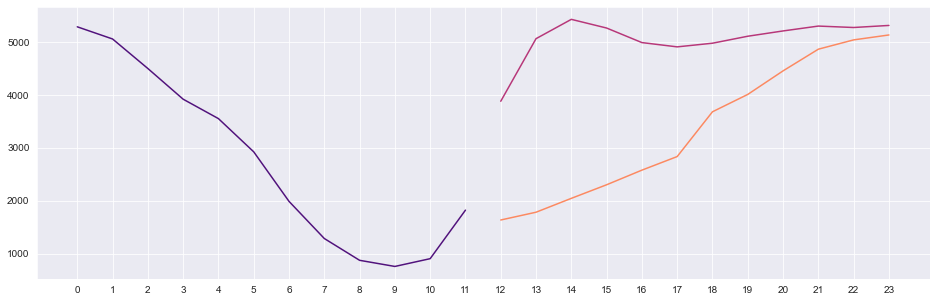

In [34]:
x_total = np.arange(0,24,1)
x_inpt = np.arange(0,12,1)
x_gt = np.arange(12,24,1)

fig, ax = plt.subplots(figsize=(16,5))

ax.plot(x_inpt, test_x[sample,:,node])
ax.plot(x_gt, test_y[sample,:,node])
ax.plot(x_gt, outputs_lr_new[sample,:,node])

ax.set_xticks(x_total);

In [35]:
rmse_lr_collect[1000]

1966.5

In [36]:
[w, b] = trained_models[10].parameters()
print(w.shape, w.data)
print(b.shape, b.data)

torch.Size([12, 12]) tensor([[ 1.6783e-01, -2.1094e-01,  8.7525e-02, -7.4152e-02,  7.2879e-02,
          4.8910e-02, -1.9927e-02,  4.1251e-02, -1.4945e-01, -1.8784e-01,
          2.7078e-01,  9.3922e-01],
        [ 7.5856e-02,  1.6702e-04, -5.4923e-02,  7.2412e-02,  1.5682e-02,
         -1.4594e-01,  1.6873e-01,  9.2330e-02, -3.0122e-01, -7.0626e-02,
          1.8609e-01,  9.2493e-01],
        [ 1.9339e-01, -9.3384e-02, -7.1732e-02,  2.1764e-01, -1.8222e-01,
          2.6580e-02,  8.4441e-02,  6.1475e-02, -2.6324e-01, -1.5583e-02,
          2.2655e-01,  7.5128e-01],
        [ 3.5371e-01, -2.1681e-01,  9.5982e-02,  5.6503e-02, -2.3144e-01,
          2.2613e-01,  9.9782e-02, -2.2927e-01, -7.9468e-02,  4.6256e-02,
          2.8158e-01,  5.4410e-01],
        [ 2.4272e-01,  1.7967e-01,  2.1094e-02, -1.9290e-01,  9.8665e-02,
         -1.0086e-01,  1.9323e-01, -1.0749e-01, -9.1733e-02,  4.3958e-02,
          1.9078e-01,  5.0470e-01],
        [ 3.5592e-01,  1.2775e-01,  2.0596e-01, -2.0338e-01

In [37]:
# To train the CNN, preds on training data itself.

In [38]:
final_outputs = []

for i in range(len(trained_models)):
    
    new_model = trained_models[i].eval()
    new_model.to(device)
    
    single_model_output = []
    
    with torch.no_grad():
        
        # enumerate the iterator correponding to the model
        for bi, (data, target) in enumerate(data_loaders[i]):
            
            data_batch, label_batch = data.float().to(device), target.float().to(device)
            
            output_batch = new_model(data_batch)
            
            output_batch_numpy = output_batch.cpu().detach().numpy()
            
            #print(output_batch_numpy.shape)
            
            single_model_output.append(np.squeeze(output_batch_numpy))
            
    final_outputs.append(single_model_output)
    
final_outputs = np.array(final_outputs)

In [39]:
print(final_outputs.shape)
final_outputs_new=[]

num_samples = final_outputs.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(final_outputs)):
        for k in range(num_samples):
            if i==k:
                selected = final_outputs[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')
      
    final_outputs_new.append(sample_collect)
    
final_outputs_new = np.array(final_outputs_new)
print(final_outputs_new.shape)

(150, 9157, 12)
(9157, 12, 150)


In [42]:
# verify
print(final_outputs[140][2000][5])
print(final_outputs_new[2000][5][140])

6725.113
6725.113


In [40]:
print(train_x_new.shape)
train_x_new_new=[]

num_samples = train_x_new.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(train_x_new)):
        for k in range(num_samples):
            if i==k:
                selected = train_x_new[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')       
        
    train_x_new_new.append(sample_collect)
    
train_x_new_new = np.array(train_x_new_new)
print(train_x_new_new.shape)

(150, 9157, 12)
(9157, 12, 150)


In [43]:
# verify
print(train_x_new[140][2000][5])
print(train_x_new_new[2000][5][140])

7378.0
7378.0


In [41]:
#save output and training data in the easy format for CNN
np.save('./lr/linear_model_train_input.npy', train_x_new_new)
np.save('./lr/linear_model_train_output.npy', final_outputs_new)